In [2]:
import io
import os
import re
import shutil
import string
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

import tensorflow_datasets as tfds
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Input, TextVectorization, Embedding
from tensorflow.keras.layers import Dense, Dropout, Bidirectional, LSTM
from tensorflow.keras.utils import plot_model

In [3]:
DATASET = "yelp_polarity_reviews" # datasets: "imdb_reviews", "yelp_polarity_reviews"

DROPOUT_RATE = 0.5
DENSE_HIDDEN_UNITS = 200
BATCH_SIZE = 64
NB_CLASSES = 2
BUFFER_SIZE = 10000
NUM_EPOCHS = 5

In [4]:
dataset, info = tfds.load(DATASET, with_info=True,
                          as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

train_dataset.element_spec

2022-05-25 19:33:08.290519: W tensorflow/core/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "Not found: Could not locate the credentials file.". Retrieving token from GCE failed with "Failed precondition: Error executing an HTTP request: libcurl code 6 meaning 'Couldn't resolve host name', error details: Could not resolve host: metadata".


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/560000 [00:00<?, ? examples/s]

Shuffling yelp_polarity_reviews-train.tfrecord...:   0%|          | 0/560000 [00:00<?, ? examples/s]

Generating test examples...:   0%|          | 0/38000 [00:00<?, ? examples/s]

Shuffling yelp_polarity_reviews-test.tfrecord...:   0%|          | 0/38000 [00:00<?, ? examples/s]

Dataset yelp_polarity_reviews downloaded and prepared to /root/tensorflow_datasets/yelp_polarity_reviews/0.2.0. Subsequent calls will reuse this data.


2022-05-25 19:35:55.882009: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-25 19:35:56.039138: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-25 19:35:56.040524: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-25 19:35:56.043774: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [5]:
for example, label in train_dataset.take(5):
  print('text: ', example.numpy())
  print('type data: ', type(example))
  print('label: ', label.numpy())

2022-05-25 19:35:59.051806: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


text:  b"The Groovy P. and I ventured to his old stomping grounds for lunch today.  The '5 and Diner' on 16th St and Colter left me with little to ask for.  Before coming here I had a preconceived notion that 5 & Diners were dirty and nasty. Not the case at all.\\n\\nWe walk in and let the waitress know we want to sit outside (since it's so nice and they had misters).  We get two different servers bringing us stuff (talk about service) and I ask the one waitress for recommendations.  I didn't listen to her, of course, and ordered the Southwestern Burger w/ coleslaw and started with a nice stack of rings.\\n\\nThe Onion Rings were perfectly cooked.  They looked like they were prepackaged, but they were very crispy and I could actually bite through the onion without pulling the entire thing out (don't you hate that?!!!)\\n\\nThe Southwestern Burger was order Medium Rare and was cooked accordingly.  Soft, juicy, and pink with a nice crispy browned outer layer that can only be achieved on 

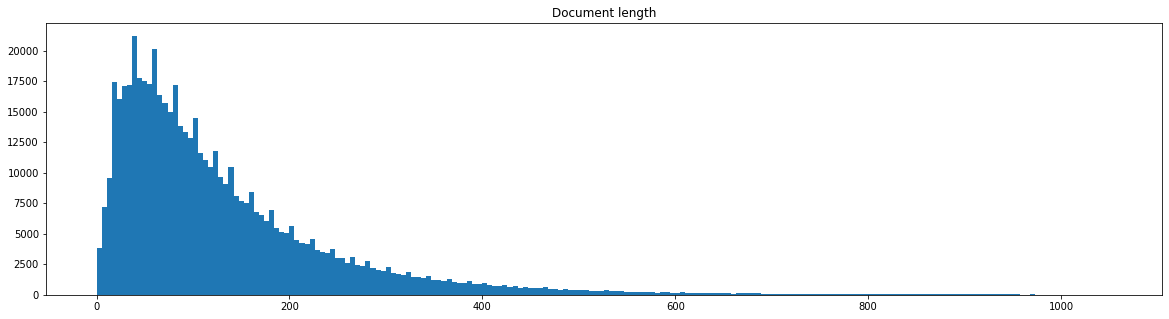

Text informations:
 - number of seq:  560000
 - max length:     1052
 - min length:     1
 - mean length:    133.0288732142857


In [6]:
num_token = [len(str(text.numpy()).split()) for text, label in train_dataset.take(count=-1)]

# Plot histogram
plt.figure(figsize=(20,5))
plt.title("Document length")
plt.hist(num_token, 200, density=False, range=(0,np.max(num_token)))
plt.show()

print("Text informations:")
print(f" - number of seq:  {len(num_token)}")
print(f" - max length:     {np.max(num_token)}")
print(f" - min length:     {np.min(num_token)}")
print(f" - mean length:    {np.mean(num_token)}")

In [7]:
VOCAB_SIZE = 10000
EMBEDDING_DIM = 100
MAX_SEQ_LENGTH = 300

In [8]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [9]:
for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])

texts:  [b"The customer service here was terrible, getting estimate is very hard. The guy who answered the phone on 9/10/12 around 4:45 pm actually hung up in my face because he couldn't another guy name Mike. Don't waste your time like I did. I read the other comments that were listed and wanted to try them for myself, unfortunately some of the comments are true regarding the customer service. I feel bad for the owner, because as a business owner myself it's very hard to find good employees and ultimately they are a reflection of the company as a whole."
 b"Big fan of the penne primavera! Delicious pasta if you are in the mood do Italian food! The pizza is always extremely good! We prefer their margarita pizza. Wouldn't recommend ordering sausage on the pizza though.."
 b'I have been to other  Zipps,  and even this one, before and the food and service have been great, which would be why we went there again today. BIG change!\\n\\nThe restaurant might have had 8 tables busy at the lunc

In [10]:
# Create a custom standardization function to strip HTML break tags '<br />'.
def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
  return tf.strings.regex_replace(stripped_html,
                                  '[%s]' % re.escape(string.punctuation), 
                                  '')

encoder = TextVectorization(
    standardize = custom_standardization,
    max_tokens =  VOCAB_SIZE,
    output_mode = 'int',
    output_sequence_length = MAX_SEQ_LENGTH)

encoder.adapt(train_dataset.map(lambda text, label: text))

In [11]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'and', 'i', 'to', 'a', 'was', 'of', 'it',
       'for', 'in', 'is', 'that', 'my', 'we', 'this', 'with', 'but',
       'they'], dtype='<U16')

In [12]:
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[   2,  207,   54,   45,    7,  462,  275, 3483,   12,   42,  329,
           2,  352,  115, 1862,    2,  441,   21,    1,  149,    1,  994,
         237, 2223,   51,   11,   14,  899,   72,   63,  318,  154,  352,
         443, 2962,   73,  774,   71,   49,   37,    4,   89,    4,  654,
           2,   80, 2616,   13,   26, 1998,    3,  185,    5,  118,   78,
          10,  486,  693,   67,    8,    2, 2616,   28,  996, 2803,    2,
         207,   54,    4,  241,  143,   10,    2,  465,   72,   34,    6,
         294,  465,  486,   47,   42,  329,    5,  178,   35,  560,    3,
        4076,   19,   28,    6, 8547,    8,    2,  561,   34,    6,  364,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0, 

In [13]:
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b"The customer service here was terrible, getting estimate is very hard. The guy who answered the phone on 9/10/12 around 4:45 pm actually hung up in my face because he couldn't another guy name Mike. Don't waste your time like I did. I read the other comments that were listed and wanted to try them for myself, unfortunately some of the comments are true regarding the customer service. I feel bad for the owner, because as a business owner myself it's very hard to find good employees and ultimately they are a reflection of the company as a whole."
Round-trip:  the customer service here was terrible getting estimate is very hard the guy who answered the phone on [UNK] around [UNK] pm actually hung up in my face because he couldnt another guy name mike dont waste your time like i did i read the other comments that were listed and wanted to try them for myself unfortunately some of the comments are true regarding the customer service i feel bad for the owner because as a busines

In [14]:
model = Sequential([
                    encoder,
                    Embedding(input_dim=VOCAB_SIZE, output_dim=EMBEDDING_DIM,
                              mask_zero=True),
                    LSTM(128, dropout=DROPOUT_RATE),
                    Dense(64, activation='relu', kernel_regularizer='l2'),
                    Dropout(DROPOUT_RATE),
                    Dense(1, activation='sigmoid')
])

In [15]:
model.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization (TextVect (None, 300)               0         
_________________________________________________________________
embedding (Embedding)        (None, 300, 100)          1000000   
_________________________________________________________________
lstm (LSTM)                  (None, 128)               117248    
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 1,125,569
Trainable params: 1,125,569
Non-trainable params: 0
______________________________________________

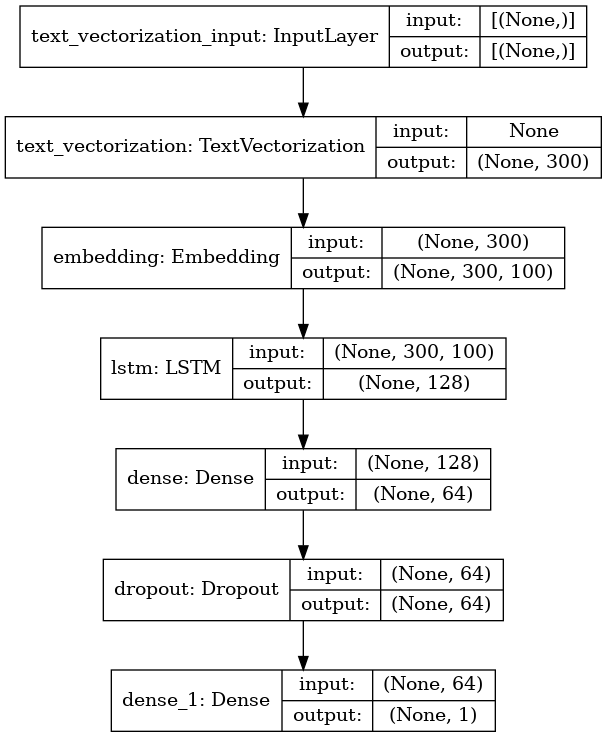

In [17]:
plot_model(model, show_shapes=True)

In [18]:
history = model.fit(train_dataset, epochs=NUM_EPOCHS,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/5


2022-05-25 19:41:55.628731: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


8750/8750 [==============================] - 331s 37ms/step - loss: 0.3134 - accuracy: 0.9019 - val_loss: 0.1734 - val_accuracy: 0.9427
Epoch 2/5
8750/8750 [==============================] - 322s 37ms/step - loss: 0.1940 - accuracy: 0.9290 - val_loss: 0.1619 - val_accuracy: 0.9411
Epoch 3/5
8750/8750 [==============================] - 330s 38ms/step - loss: 0.1730 - accuracy: 0.9358 - val_loss: 0.1368 - val_accuracy: 0.9510
Epoch 4/5
8750/8750 [==============================] - 336s 38ms/step - loss: 0.1567 - accuracy: 0.9426 - val_loss: 0.1239 - val_accuracy: 0.9573
Epoch 5/5
8750/8750 [==============================] - 342s 39ms/step - loss: 0.1444 - accuracy: 0.9472 - val_loss: 0.1146 - val_accuracy: 0.9599


In [19]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

594/594 [==============================] - 12s 20ms/step - loss: 0.1392 - accuracy: 0.9478
Test Loss: 0.1392204910516739
Test Accuracy: 0.9478421211242676


In [20]:
import matplotlib.pyplot as plt


def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

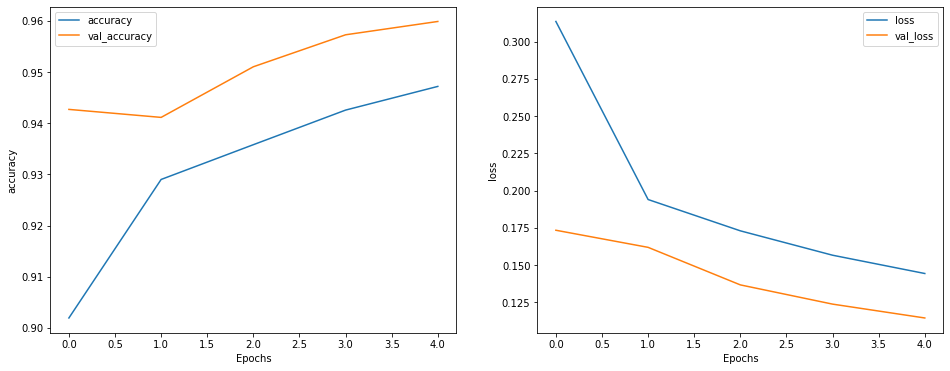

In [21]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')

In [22]:
model1 = tf.keras.Sequential([
    encoder,
    Embedding(input_dim=VOCAB_SIZE, output_dim=EMBEDDING_DIM,
                              mask_zero=True),
    LSTM(256, dropout=DROPOUT_RATE, return_sequences=True),
    LSTM(128, dropout=DROPOUT_RATE, return_sequences=True),
    LSTM(64, dropout=DROPOUT_RATE),
    Dense(64, activation='relu', kernel_regularizer='l2'),
    Dropout(DROPOUT_RATE),
    Dense(1, activation='sigmoid')
])

In [23]:
model1.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [24]:
model1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization (TextVect (None, 300)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 300, 100)          1000000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 300, 256)          365568    
_________________________________________________________________
lstm_2 (LSTM)                (None, 300, 128)          197120    
_________________________________________________________________
lstm_3 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)               

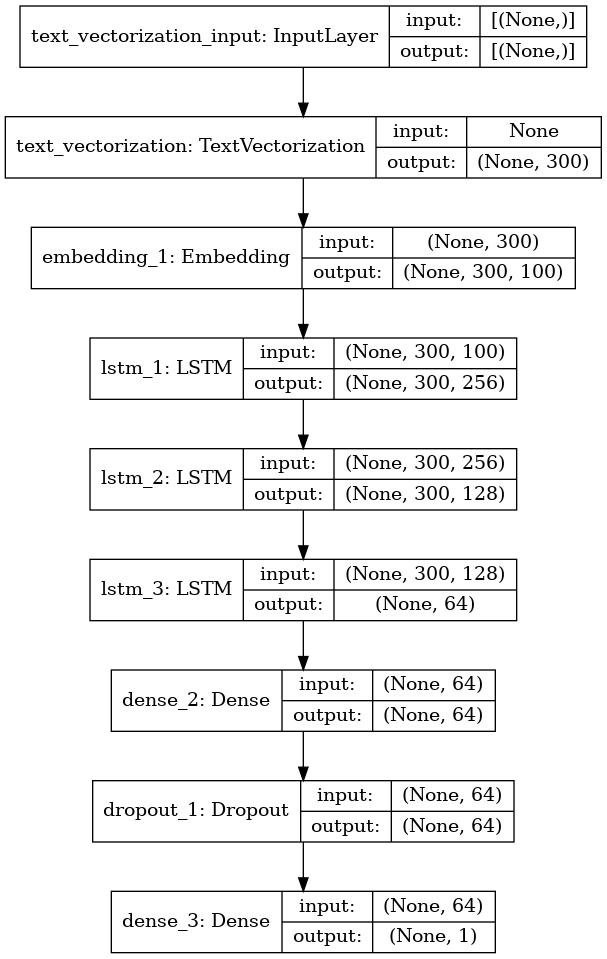

In [25]:
plot_model(model1, show_shapes=True)

In [26]:
history1 = model1.fit(train_dataset, epochs=NUM_EPOCHS,
                      validation_data=test_dataset,
                      validation_steps=30)

Epoch 1/5
8750/8750 [==============================] - 806s 91ms/step - loss: 0.3045 - accuracy: 0.9048 - val_loss: 0.1608 - val_accuracy: 0.9359
Epoch 2/5
8750/8750 [==============================] - 785s 90ms/step - loss: 0.1873 - accuracy: 0.9300 - val_loss: 0.1555 - val_accuracy: 0.9432
Epoch 3/5
8750/8750 [==============================] - 777s 89ms/step - loss: 0.1637 - accuracy: 0.9399 - val_loss: 0.1232 - val_accuracy: 0.9578
Epoch 4/5
8750/8750 [==============================] - 783s 89ms/step - loss: 0.1460 - accuracy: 0.9464 - val_loss: 0.1158 - val_accuracy: 0.9630
Epoch 5/5
8750/8750 [==============================] - 783s 89ms/step - loss: 0.1350 - accuracy: 0.9508 - val_loss: 0.1118 - val_accuracy: 0.9641


In [27]:
test_loss, test_acc = model1.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

594/594 [==============================] - 22s 36ms/step - loss: 0.1325 - accuracy: 0.9521
Test Loss: 0.1324567198753357
Test Accuracy: 0.9521315693855286


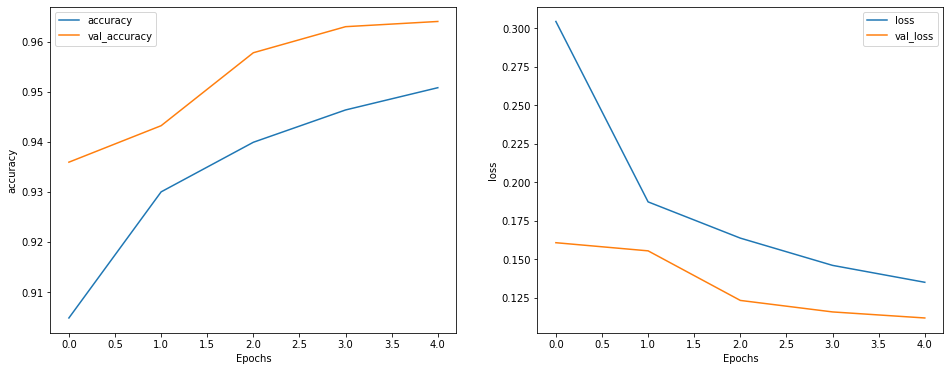

In [28]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history1, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history1, 'loss')